### Simflux localization example

This google colab notebook:

1.   Downloads the SIMFLUX code (https://github.com/jcnossen/sf2.git)
2.   Clones and builds the C++/CUDA PSF fitting code https://gitlab.com/jcnossen/fastpsf.git
3.   Downloads SIMFLUX 80nm nanorulers (4GB so takes a while)
4.   Performs all localization, processing.

Resulting files end up in /content/results/sim4_1


In [ ]:
# Workaround for some weird colab locale issue
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# %%capture will hide the output
%cd /content
!rm -rf /content/fastpsf
!git clone https://gitlab.com/jcnossen/fastpsf.git
%cd /content/fastpsf
!cmake .
!make clean & make
%cd /content/fastpsf/python/
!python setup.py develop

# Check that fastpsf + CUDA is running ok by evaluating a 2D Gaussian..
from fastpsf import Context, GaussianPSFMethods
import matplotlib.pyplot as plt

with Context() as ctx:
  roisize =12
  psf = GaussianPSFMethods(ctx).CreatePSF_XYIBg(roisize, sigma = 2, cuda=True)
  plt.imshow(psf.GenerateSample([[roisize/2,roisize/2,200,2]])[0])


In [ ]:
# %%capture will hide the output
#%%capture
%cd /content
!rm -rf /content/sf2
!git clone https://github.com/jcnossen/sf2.git
%cd /content/sf2
!python setup.py develop

## Download SIMFLUX 80nm nanoruler dataset

In [ ]:
import os
from smlmtorch.util.download import download
url = 'https://zenodo.org/record/7771932/files/sim4_1_MMStack_Pos0.ome.tif?download=1'
path = "/content/sim4_1.tif"
if not os.path.exists(path):
  download(url, path)



Processing /content/sim4_1.tif with 13210 frames
moving_window=True


100%|█████████▉| 79230/79260 [01:23<00:00, 947.37it/s]


Num ROIs: 1226447
Found /content/cache/sim4_1/summed_fits_cfg.pickle, but cache needs rebuild.


Fitting with known PSF sigma: 100%|██████████| 1226447/1226447 [00:31<00:00, 39088.23it/s]


Removing 3 localizations with NaN
Remaining localizations: 1133368/1226447
Chi-sq filtered: 1119656/1133368
crlb filter: 1061297/1119656
Saving Picasso-compatible hdf5 to /content/results/sim4_1/smlm_crlb30.hdf5
Median intensity: 96. Bg: 9.71 Median CRLB: X=21.4 nm Y=21.4 nm. (0.33, 0.33 px)
Saving Picasso-compatible hdf5 to /content/results/sim4_1/smlm.hdf5
Angle: 90.07, Pitch: 219.89 nm
Angle: 0.04, Pitch: 219.48 nm


100%|██████████| 524/524 [00:40<00:00, 12.88it/s]


Found /content/cache/sim4_1/sf_fits_cfg.pickle, but cache needs rebuild.


100%|██████████| 230675/230675 [00:03<00:00, 68024.00it/s]


Saving Picasso-compatible hdf5 to /content/results/sim4_1/sf.hdf5


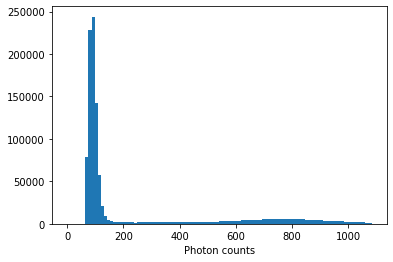

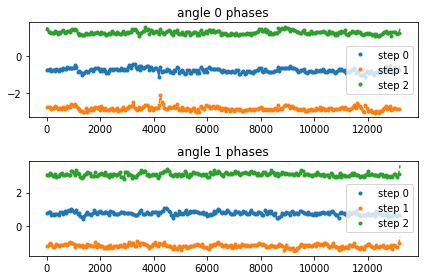

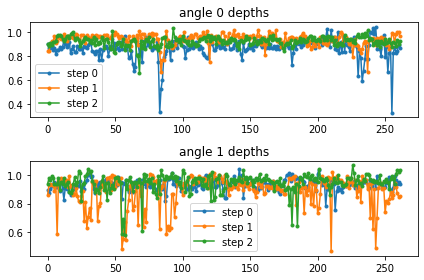

In [94]:
from smlmtorch.simflux import SFLocalizer
from smlmtorch.ui.array_view import array_view
import numpy as np

# Configuration for spot detection and 2D Gaussian fitting
cfg = {
    'psf_calib':[1.8,1.8],
   'roisize':10,
   'detection_threshold':4,
   'pattern_frames': [[0,2,4],[1,3,5]],
   'gain': 0.45,
   'offset': 100,
   'pixelsize' : 65 # nm/pixel
}

cfg['psf_calib']=[1.3,1.3]; cfg['detection_threshold']=1.5

sfloc = SFLocalizer(path, **cfg, device='cuda:0')

sfloc.detect_spots(ignore_cache=False, moving_window=True)

ds = sfloc.fit_smlm(max_crlb_xy=30, min_photons=400)
ds.save(sfloc.result_dir + "smlm.hdf5")

mp = sfloc.estimate_angles(pitch_minmax_nm=[100,1000])
mp = sfloc.estimate_phases(mp, frame_binsize=4000, accept_percentile=30, iterations=10, verbose=False)

# Filter by modulation error
ds_filtered = ds[mp.mod_error(ds) < 0.1]
sf_ds = sfloc.fit_simflux(mp, ds_filtered, iterations=50, lambda_=500, normalizeWeights=True, ignore_cache=False)



Dataset with 1119656 2D localizations (400x400 pixel image).
Dataset with 226818 2D localizations (400x400 pixel image).


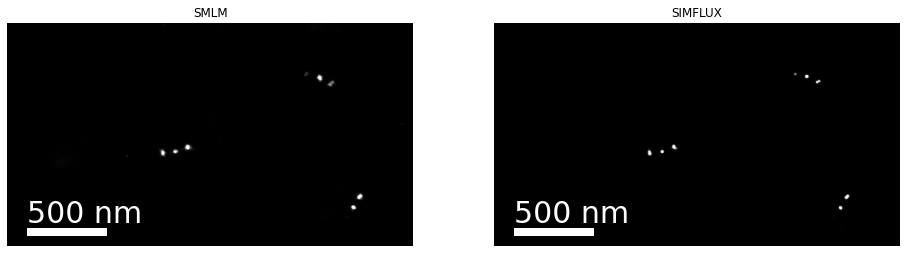

In [91]:
from smlmtorch import Dataset

figsize=(16,8)
zoom = 20

datasets=[
    ('smlm', 'SMLM'),
    ('sf', 'SIMFLUX'),
    ]

fig,ax=plt.subplots(ncols=2, figsize=figsize)
for i,(fn,label) in enumerate(datasets):
  ds = Dataset.load(sfloc.result_dir + f'{fn}.hdf5')
  ds['pixelsize'] = cfg['pixelsize']

  print(ds)
  ds.crop(minpos = (170, 188), maxpos = (210, 210), silent=True).renderFigure(axes=ax[i],title=label, 
                      zoom=zoom, clip_percentile=99.95, scalebar_nm=500,
                      scalebar_fontsize=30, cmap='gray')


Keeping 268978/270155 spots
Elapsed time: 17.2 s. FRC=21.48 nm
Keeping 196160/196225 spots
Elapsed time: 16.6 s. FRC=12.75 nm


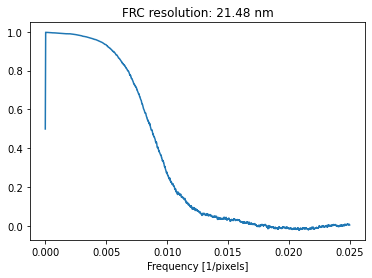

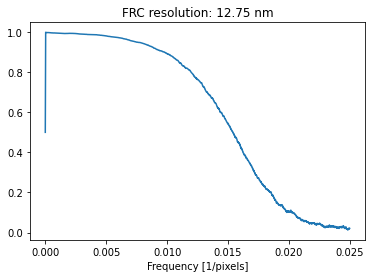

In [60]:

frc_curves = []
frc_val = []

for fn,label in datasets:
    ds = Dataset.load(sfloc.result_dir + f'{fn}.hdf5')
    ds['pixelsize'] = cfg['pixelsize']
    
    ds.crlb_filter(0.2)

    zoom=20    
    ds_frc, frc_curve = ds.frc(display=True, zoom=zoom, smooth=10)

